In [ ]:
# Common libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt

# Linear regression Question libraries
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge

# Logistic Regression Question Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import seaborn as sns

import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import transformers
import torch
torch.manual_seed(448)
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

# from imblearn.over_sampling import RandomUnderSampler

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Connect with Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
# TODO: change this to the path to your homework folder
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'EECS_448_Final_NN/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))
# Load the autoreload extension
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

['Combined_Goodreads_Data.csv', 'copy of Anna_NN_BERT.ipynb', 'EECS 448 final NN.ipynb', 'Vidhur_NN_BERT.ipynb', 'Copy of Lillian_NN_BERT.ipynb']


In [ ]:
# Installations
! pip install transformers

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


### Getting the Data Set Up

In [ ]:
#file_path = '/Combined_Goodreads_Data.csv'
df = pd.read_csv(GOOGLE_DRIVE_PATH + "Combined_Goodreads_Data.csv")
# print(df.head(10))

# df_filtered = df[df['n_votes'] > 0]
# plt.figure(figsize=(10, 6))
# plt.hist(df_filtered['n_votes'], bins=5, range=(0, 80), color='skyblue', edgecolor='black')
# plt.title('Distribution of n_votes (excluding 0)')
# plt.xlabel('n_votes')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.xlim(0, 100)  # Set x-axis limits
# plt.show()

In [ ]:
# Converting the dates
from datetime import datetime
import pandas as pd

df = pd.DataFrame(df)

# Convert date_added column to datetime objects
try:
    df['date_added'] = pd.to_datetime(df['date_added'], utc=True)
except ValueError as e:
    print("Error converting date_added column:", e)

# Format datetime objects as desired
if 'date_added' in df.columns:
    df['formatted_date_added'] = df['date_added'].dt.strftime("%m/%d/%Y")

# print(df['formatted_date_added'])

# Filter out instances where n_votes is 0
df = df[df['n_votes'] != 0]
print(type(df['n_votes']))
# Define bins
df['n_votes_bin'] = pd.qcut(df['n_votes'], q=6, labels=False , duplicates='drop')
df = df[df['n_votes_bin'] != 1]
df = df[df['n_votes_bin'] != 2]
df = df[df['n_votes_bin'] != 3]

#df = df.reset_index()
# Display the value counts of the bins
print(df['n_votes_bin'].value_counts())

<class 'pandas.core.series.Series'>
n_votes_bin
0    7504
4    2742
Name: count, dtype: int64


In [ ]:
df['formatted_date_added'] = pd.to_datetime(df['formatted_date_added'], utc=True)
df['publication_date'] = pd.to_datetime(df['publication_date'])

df['formatted_date_added'] = pd.to_datetime(df['formatted_date_added']).dt.tz_localize(None)

# Calculate the time difference between publication_date and date_added
df['time_difference_days'] = (df['formatted_date_added'] - df['publication_date']).dt.days

print(df['time_difference_days'])

5        3716
7        3604
8        2504
13       3335
15       2921
         ... 
54922    2610
54924    3984
54929    2997
54930    2842
54943    4378
Name: time_difference_days, Length: 10246, dtype: int64


In [ ]:
df['review_word_count'] = df['review_text'].str.split().str.len()

# print(df['review_word_count'])

In [ ]:
df['num_reviews'] = df.groupby('user_id')['user_id'].transform('size')

In [ ]:
df['num_book'] = df.groupby('book_id')['book_id'].transform('size')
# print(df['num_book'])

In [ ]:
nltk_stopwords = set(stopwords.words('english'))

def PreprocessSentence(sentence, nltk_stopwords):
    # Input - a sentence in the form of a python string, and the set of stopwords
    # Output - the preprocessed sentence, as per the instructions

    sentence = sentence.lower()
    tokens = word_tokenize(sentence)
    #remove stopwords and single char non-num words
    tokens = [word for word in tokens if word not in nltk_stopwords and (word.isnumeric() or len(word) > 1)]
    preprocessed_sentence = ' '.join(tokens)
    return preprocessed_sentence

def PreprocessData(df, nltk_stopwords):
    # Input - the dataframe, with columns label and text, and the set of stopwords
    # output - the dataframe with the text processed as described earlier
    df['review_text'] = df['review_text'].map(lambda x: PreprocessSentence(x, nltk_stopwords))
    return df
df = PreprocessData(df, nltk_stopwords)

In [ ]:
#df_bert['n_votes_bin'].value_counts()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
x_reshape = df['review_text'].values.reshape(-1, 1)
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=448)
X_resampled, y_resampled = undersampler.fit_resample(x_reshape, df['n_votes_bin'])
print(X_resampled)
print(len(X_resampled))

[["3.5 hehehe like cabot 's stories 're laid back easy read high drama bubble hilariously along right amount romance took couple chapters really got reading easy sure might touch predictable n't care sometimes works yeah n't much say reading felt like break nice"]
 ["wonderful reading always zusak ca n't fail love style love love love stories marvellous book"]
 ["9 minutes past six evening writing review murder mystery novel like murder mystery novels involve puzzles try solve mystery answer revealed novel reviewing written boy asperger 's syndrome like reviews always know someone thought book reviewing number stars given novel top review social convention books marked five stars give liked book convention set agreed stipulated generally accepted standards liked book lot gave five stars first drew book title title long unusual novel title book 'the curious incident dog night-time says author mark haddon n't read book author actually christopher boone one mysteries contained within book

In [ ]:
# commented out for now but theis is where the other feature vectors are created

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# # Sample DataFrame
# df = pd.DataFrame(df)

# analyzer = SentimentIntensityAnalyzer()
# df["review_sentiment"] = df["review_text"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

# # Create feature vector
# feature_vector = df[['time_difference_days', 'review_word_count', 'num_reviews', 'rating', 'review_sentiment', 'num_book']]

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(feature_vector, df['n_votes_bin'], test_size=0.2, random_state=42)

In [ ]:
# sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=448)
# X_train_idxs, y_train_idxs= sss.split(df['review_text'], df['n_votes_bin'])
# print(X_train_idxs)
# print(y_train_idxs)
# print(X_test_idxs)
# print(y_test_idxs)

# splitter=StratifiedShuffleSplit(n_splits=1,random_state=12)

# for train,test in splitter.split(df['review_text'], df['n_votes_bin']):     #this will splits the index
#     X_train_SS = df['review_text'].iloc[train]
#     y_train_SS = df['n_votes_bin'].iloc[train]
#     X_test_SS = df['review_text'].iloc[test]
#     y_test_SS = df['n_votes_bin'].iloc[test]

In [ ]:
df_bert = pd.DataFrame({'review_text': X_resampled.flatten(), 'n_votes_bin': y_resampled})
df_bert['n_votes_bin'].value_counts()
# df_bert = df[['review_text', 'n_votes_bin']]

n_votes_bin
0    2742
4    2742
Name: count, dtype: int64

## DistilBERT

In [ ]:
class MultiLabelDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.review_text
        self.targets = self.data.n_votes_bin
        self.max_len = max_len

    def __len__(self):
      # TODO: Return the number of the text inputs
      return len(self.data)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=False,
            truncation = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']


        if self.targets[index] == 0:
          new_label = 0
        elif self.targets[index] == 4:
          new_label = 1
        else:
          print('Unexpected label', self.targets[index])


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(new_label, dtype=torch.int)
        }

In [ ]:
df_bert.n_votes_bin

0       0
1       0
2       0
3       0
4       0
       ..
5479    4
5480    4
5481    4
5482    4
5483    4
Name: n_votes_bin, Length: 5484, dtype: int64

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

print(df_bert.shape)
df_bert, valid_df = train_test_split(df_bert, test_size=0.2, random_state=448)

df_bert = df_bert.reset_index()
valid_df = valid_df.reset_index()

print(df_bert.shape)
print(valid_df.shape)

training_set = MultiLabelDataset(df_bert, tokenizer, max_len=400)
valid_set = MultiLabelDataset(valid_df, tokenizer, max_len=400)

training_loader = DataLoader(training_set, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=True, num_workers=0)

(5484, 2)
(4387, 3)
(1097, 3)


In [ ]:
print(df_bert)

      index                                        review_text  n_votes_bin
0      1793  review originally posted books bottles accurat...            0
1      1583  bleak post-apocalyptic story man son land almo...            0
2       767  volume kicks chapter 80 clean-up 'll write edi...            0
3       663  short book quaint really still something 's gr...            0
4      4541  sigh read book 2008 hype highest point enjoy p...            4
...     ...                                                ...          ...
4382   1585  country somewhere south america birthday party...            0
4383     78                    deserve 'm blinded tears review            0
4384   2305      leo gursky top-five fictional characters time            0
4385   2300  awsome book came book accident searching anoth...            0
4386   4060  bear lot thoughts 've thought reading book yea...            4

[4387 rows x 3 columns]


In [ ]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # freeze distilbert layers
        for param in self.distilbert.parameters():
            param.requires_grad = False

        self.fc1 = torch.nn.Linear(768, 768)
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p = 0.2)
        self.fc2 = torch.nn.Linear(768, 384)
        # change number of bins
        self.fc3 = torch.nn.Linear(384, 2)

    def forward(self, input_ids, attention_mask):
        self.hidden = self.distilbert(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)[0]
        x = self.hidden[:, 0, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [ ]:
def train():
  num_epochs = 5
  train_loss_history = []
  train_acc_history = []
  for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    total_loss = 0
    total = 0
    correct = 0

    model.train()
    for batch_data in training_loader:
    # for i, batch_data in tqdm(enumerate(training_loader), total=len(training_loader)):
      # is this how to get the inputs on the same device, taken from lab
      input_ids = batch_data['ids'].to(device)
      attention_mask = batch_data['mask'].to(device)
      targets = batch_data['targets'].type(torch.LongTensor).to(device)
      #print(input_ids)
      #print(targets)
      #batch_data = batch_data.to(device)
      #batch_data = batch_data.cuda()
      outputs = model(input_ids, attention_mask)
      #print(outputs.dtype)
      #print(targets)
      loss = loss_fn(outputs, targets)
      # print(f"Loss: {loss}")
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Stats
      total_loss += loss.item()
      total += targets.size(0)
      _, prediction = torch.max(outputs.data, 1)
      # print(prediction)
      correct += (prediction == targets).sum().item()

    print(f"Total Loss: {total_loss/total}")
    print(f"Total Accuracy: {100*(correct/total)}")
    train_loss_history.append(total_loss/total)
    train_acc_history.append(100*(correct/total))
  return train_loss_history, train_acc_history

In [ ]:
# CUDA_LAUNCH_BLOCKING=1
tlh, tah = train()

Epoch: 0
Total Loss: 2.9013571221914702
Total Accuracy: 50.64964668338272
Epoch: 1
Total Loss: 0.2549424804246097
Total Accuracy: 50.011397310234784
Epoch: 2
Total Loss: 0.1782572355918741
Total Accuracy: 50.03419193070435
Epoch: 3
Total Loss: 0.17624403087620533
Total Accuracy: 50.05698655117392
Epoch: 4
Total Loss: 0.1868391643291675
Total Accuracy: 49.988602689765216


In [ ]:
# def validation(testing_loader):
#     model.eval()
#     pred_list = []
#     actual_list = []
#     with torch.no_grad():
#       for batch_data in testing_loader:
#         input_ids = batch_data['ids'].to(device)
#         attention_mask = batch_data['mask'].to(device)
#         actual = batch_data['targets'].to(device)

#         pred = model(input_ids, attention_mask)
#         pred_list.append(pred.cpu().numpy())
#         actual_list.append(actual.cpu().numpy())

#     return np.vstack(pred_list), np.vstack(actual_list)

In [ ]:
def validation(testing_loader):
    model.eval()
    pred_list = []
    actual_list = []
    with torch.no_grad():
        for batch_data in testing_loader:
            input_ids = batch_data['ids'].to(device)
            attention_mask = batch_data['mask'].to(device)
            actual = batch_data['targets'].to(device)
            logits = model(input_ids, attention_mask)
            pred_list.append(logits.cpu().numpy())
            actual_list.append(actual.cpu().numpy())
    # for i in range(len(pred_list)):
    #   print(f"Prediction at index {i}: ")
    #   print(pred_list[i])
    #   print(np.shape(pred_list[i]))
    # print(actual_list)
    return np.concatenate(pred_list), np.concatenate(actual_list)

In [ ]:
outputs, targets = validation(valid_loader)

# TODO: Convert the output to match the labels (binarize)
# final_outputs = (torch.sigmoid(torch.tensor(outputs)) > 0.5).cpu().numpy()
# final_outputs = np.concatenate(outputs, axis=0)
# final_outputs = (final_outputs > 0.5).astype(int)

In [ ]:
len(df_bert)

11468

In [ ]:
np.shape(outputs)
print(outputs)

[[ 0.11591198 -0.11919928]
 [ 0.11591198 -0.11919928]
 [ 0.11591198 -0.11919928]
 ...
 [ 0.11591198 -0.11919928]
 [ 0.11591198 -0.11919928]
 [ 0.11591198 -0.11919928]]


In [ ]:
np.reshape(targets, -1)

array([1, 0, 1, ..., 1, 0, 0], dtype=int32)

In [ ]:
np.argmax(outputs, axis=1)
outputs

array([[ 0.11591198, -0.11919928],
       [ 0.11591198, -0.11919928],
       [ 0.11591198, -0.11919928],
       ...,
       [ 0.11591198, -0.11919928],
       [ 0.11591198, -0.11919928],
       [ 0.11591198, -0.11919928]], dtype=float32)

[[557 540]
 [  0   0]]


<Axes: >

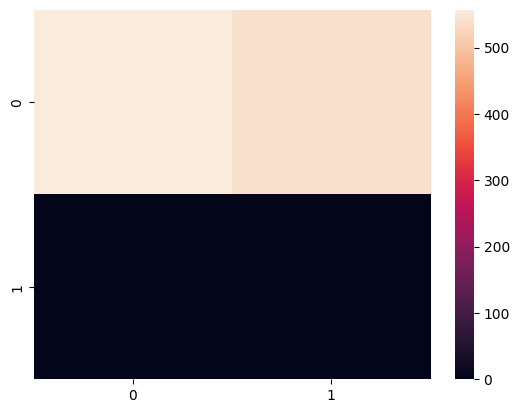

In [ ]:
# np.sum(np.argmax(outputs, axis=1) ==
# np.shape(np.reshape(targets, -1))
np.sum(np.argmax(outputs, axis=1) == np.reshape(targets, -1))

conf_mat = metrics.confusion_matrix(np.argmax(outputs, axis=1), np.reshape(targets, -1))
print(conf_mat)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [0, 1, 2, 3, 4])
sns.heatmap(conf_mat)
# cm_display.plot()
# plt.show()

# actual raw outputs to see if truly learning 0 and 4
# look at loss scores
# change model


# stratified splits

In [ ]:
# # Load the data
# #df = pd.read_csv(GOOGLE_DRIVE_PATH + "Combined_Goodreads_Data.csv")

# # Filter out instances where n_votes is 0
# df_filtered = df[df['n_votes'] != 0]

# # Preprocess the data
# df_preprocessed = PreprocessData(df_filtered, nltk_stopwords)

# # Create the feature vector for the entire preprocessed dataset
# feature_vector = df_preprocessed[['time_difference_days', 'review_word_count', 'num_reviews', 'rating', 'review_sentiment', 'num_book']]

# # Split the dataset into training and validation sets
# train_df, valid_df = train_test_split(df_preprocessed, test_size=0.2, random_state=448)

# # Create the feature vector for the validation set
# valid_feature_vector = valid_df[['time_difference_days', 'review_word_count', 'num_reviews', 'rating', 'review_sentiment', 'num_book']]

# # Ensure the indices are aligned
# valid_feature_vector.reset_index(drop=True, inplace=True)

# # Perform validation
# valid_outputs, valid_targets = validation(valid_loader)

# # Concatenate the logits with the feature vector for the validation set
# combo_df_valid = np.concatenate([valid_outputs, valid_feature_vector], axis=-1)


In [ ]:
#The hamming score is used to measure the similarity between two sets of binary data by calculates the number of correctly matched elements.
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
# TODO: Calculate the hamming score between the real and actual values
val_hamming_score = hamming_score(targets, final_outputs, normalize=True, sample_weight=None)

print(f"Hamming Score = {val_hamming_score}")

In [ ]:
targets[0:10]

In [ ]:
# TODO: Calculate the per class accuracy
# correct = np.sum(targets == final_outputs[:targets.shape[0]], axis=0)
# accuracy_per_class = correct / targets.shape[0]
# print(f"Per Class Accuracy = {accuracy_per_class}")
confusion_matrix = metrics.multilabel_confusion_matrix(final_outputs, targets)
for conf_mat in confusion_matrix:
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [False, True])
  cm_display.plot()
  plt.show()
  # confusion_matrix

In [ ]:
print(np.sum(final_outputs))
# print(targets[0:10])

# no True was predictred

Adding the other features to the BERT features

In [ ]:
# need to concatenate the last hidden state of BERT together with the feature vector
# I am uncertain of the shape of the BERT output so this might have to be changed around but I think it is (N, 768)
# https://www.geeksforgeeks.org/how-to-join-tensors-in-pytorch/
# combo_df = torch.cat([outputs.last_hidden_state, feature_vector], -1)
model.hidden